In [1]:
# COVID-19 Ventilator Demand Forecasting
# ======================================

# This notebook implements a forecasting model for COVID-19 ventilator bed occupancy
# using enhanced LSTM networks with comprehensive feature engineering.

# %% [markdown]
# ## Setup and Imports

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# For interactive visualizations
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.io as pio
import plotly.express as px
from itertools import cycle
pio.templates.default = "plotly_white"

# Deep learning imports
import torch
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import holidays
from datetime import datetime, timedelta

# Configure paths
import sys
import os
sys.path.append(os.path.abspath('../'))

# From our custom modules
from src.utils import plotting_utils
from src.dl.dataloaders import TimeSeriesDataModule
from src.dl.multivariate_models import SingleStepRNNConfig, SingleStepRNNModel
from src.transforms.stationary_utils import check_seasonality, check_trend, check_heteroscedastisticity

# Set up progress bar for pandas operations
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
# %% [markdown]
# ## Setting Seed for Reproducibility

# %%
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
pl.seed_everything(SEED, workers=True)

# Set PyTorch to use deterministic algorithms
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.set_float32_matmul_precision("high")

Seed set to 42


In [3]:
# %%
# Check if GPU is available
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
    # Enable memory optimization
    torch.cuda.empty_cache()
else:
    print("GPU is not available, using CPU")
    device = torch.device('cpu')


GPU is available: NVIDIA T600 Laptop GPU


In [4]:
# Define source data path
source_data = Path("../data/")

# Load the data
try:
    data = pd.read_csv(source_data / "processed" / "merged_nhs_covid_data.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print("Data file not found. Please check the path.")
    
# Display the first few rows
data.head()

Data loaded successfully with 6264 rows and 14 columns


,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,openstreetmap_id,latitude,longitude
0,East of England,2020-04-01,0.0,1400,833.0,167,334.0,75.0,2938.0,455.0,6235410,151336,52.24,0.41
1,East of England,2020-04-02,119.0,1584,841.0,184,372.0,71.0,3310.0,526.0,6235410,151336,52.24,0.41
2,East of England,2020-04-03,162.0,1776,914.0,192,350.0,85.0,3660.0,611.0,6235410,151336,52.24,0.41
3,East of England,2020-04-04,171.0,1939,988.0,163,268.0,70.0,3928.0,681.0,6235410,151336,52.24,0.41
4,East of England,2020-04-05,219.0,2159,1230.0,220,281.0,91.0,4209.0,772.0,6235410,151336,52.24,0.41


In [5]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# List all the unique values in the 'areaName' column
unique_areas = data['areaName'].unique()
print(f"Unique areas: {unique_areas}")
print(f"Number of unique areas: {len(unique_areas)}")

Missing values per column:
Series([], dtype: int64)
Unique areas: ['East of England' 'London' 'Midlands' 'North East and Yorkshire'
 'North West' 'South East' 'South West']
Number of unique areas: 7


In [6]:
# %%
# Aggregate data to a single 'England' region
# This combines all individual regions into one aggregate view
data = data.groupby('date').agg({
    'covidOccupiedMVBeds': 'sum',
    'cumAdmissions': 'sum',
    'hospitalCases': 'sum',
    'newAdmissions': 'sum',
    'new_confirmed': 'sum',
    'new_deceased': 'sum',
    'cumulative_confirmed': 'sum',
    'cumulative_deceased': 'sum',
    'population': 'sum',
    'openstreetmap_id': 'first',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()
data['areaName'] = 'England'

# Create time-based features
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
data['quarter'] = data['date'].dt.quarter
data['week_of_year'] = data['date'].dt.isocalendar().week.astype(int)

In [7]:
# %% [markdown]
# ## Stationarity and Seasonality Analysis 

# %%
# Check for stationarity and seasonality in our target variable
target_series = data['covidOccupiedMVBeds']

# Check for trend
trend_result = check_trend(target_series, confidence=0.05)
print(f"Trend detected: {trend_result.trend}, Direction: {trend_result.direction}")

# Check for seasonality
seasonality_result = check_seasonality(target_series, max_lag=365)
print(f"Seasonality detected: {seasonality_result.seasonal}, Period: {seasonality_result.seasonal_periods}")

# Check for heteroscedasticity
hetero_result = check_heteroscedastisticity(target_series)
print(f"Heteroscedasticity detected: {hetero_result.heteroscedastic}")

Trend detected: True, Direction: decreasing
Seasonality detected: True, Period: 282
Heteroscedasticity detected: True
Seasonality detected: True, Period: 282
Heteroscedasticity detected: True


In [8]:
# %% [markdown]
# ## Synthetic Vaccination Index Creation
# 
# This index models the effect of vaccination on ICU admission risk

# %%
def calculate_vax_index(df):
    """
    Calculate a synthetic vaccination index that models the effect of vaccination on ICU admission risk.
    This is an epidemiological model that estimates population immunity over time.
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame containing date and other COVID-19 related columns
    
    Returns:
    -------
    pd.DataFrame
        DataFrame with an additional 'Vax_index' column
    """
    # Constants
    total_population = 60_000_000  # Approximate England population
    number_of_age_groups = 5
    
    # Vaccine efficacy by age group (first dose)
    vaccine_efficacy_first_dose = [0.89, 0.427, 0.76, 0.854, 0.75]
    
    # Vaccine efficacy by age group (second dose)
    vaccine_efficacy_second_dose = [0.92, 0.86, 0.81, 0.85, 0.80]
    
    # ICU admission risk by age group
    age_group_probabilities_icu = [0.01, 0.02, 0.05, 0.1, 0.15]
    
    # Monthly increase in vaccination rate after vaccination starts
    monthly_vaccination_rate_increase = 0.05
    
    # Vaccination program start date
    vaccination_start_date = pd.Timestamp('2021-01-18')
    
    # Population per age group (equal distribution for simplicity)
    population_per_age_group = total_population / number_of_age_groups
    
    # Initialize Vax index list
    vax_index_list = []
    
    # Monthly vaccination rate (starting from 0)
    monthly_vaccination_rate = 0.0
    
    for index, row in df.iterrows():
        # Increment monthly vaccination rate on the first day of each month after start date
        if row['date'].day == 1 and row['date'] >= vaccination_start_date:
            monthly_vaccination_rate += monthly_vaccination_rate_increase
            # Ensure vaccination rate does not exceed 1
            monthly_vaccination_rate = min(monthly_vaccination_rate, 1.0)
            if index % 30 == 0:  # Reduce verbosity of output
                print(f"Updated monthly vaccination rate to {monthly_vaccination_rate:.2f} on {row['date'].strftime('%Y-%m-%d')}")
        
        Si_sum = 0.0
        
        for i in range(number_of_age_groups):
            # Vaccinated population for this age group
            vaccinated_population = monthly_vaccination_rate * population_per_age_group
            
            # Assume half received first dose and half received second dose
            aij = vaccinated_population / 2  # First dose
            bij = vaccinated_population / 2  # Second dose
            cij = population_per_age_group - aij - bij  # Unvaccinated
            
            # Calculate S''i based on vaccine efficacy (protected population)
            S_double_prime_i = (vaccine_efficacy_second_dose[i] * bij +
                               vaccine_efficacy_first_dose[i] * aij)
            
            # Calculate Si (effective susceptible population)
            Si = aij + bij + cij - S_double_prime_i  
            
            # Age-specific probability of ICU admission
            pi = age_group_probabilities_icu[i]
            
            # Normalize Si by total population in age group
            Si_normalized = Si / population_per_age_group
            
            # Weighted sum (vulnerability index)
            Si_sum += pi * Si_normalized
        
        # Vax index for the day (lower is better - less vulnerable population)
        vax_index = Si_sum
        vax_index_list.append(vax_index)
    
    # Add Vax index to the dataframe
    df['Vax_index'] = vax_index_list
    print("Calculated Vax_index for all dates.")
    return df

# Apply the vaccination index calculation
data = calculate_vax_index(data)


Calculated Vax_index for all dates.


In [9]:
# %%
# Visualize key time series data
# Create a subplot with 5 rows to visualize different aspects of the data
fig = sp.make_subplots(
    rows=5, cols=1, 
    shared_xaxes=True, 
    subplot_titles=(
        'New Hospital Admissions', 
        'Current Hospital Cases',
        'Mechanical Ventilator Bed Usage',
        'New COVID-19 Cases',
        'Vax Index'
    ),
    vertical_spacing=0.08,
    row_heights=[0.2, 0.2, 0.2, 0.2, 0.2]
)

# Plot for New Hospital Admissions
fig.add_trace(go.Scatter(
    x=data['date'], 
    y=data['newAdmissions'], 
    line=dict(color='brown', width=2), 
    name='New Admissions'
), row=1, col=1)

# Plot for Current Hospital Cases
fig.add_trace(go.Scatter(
    x=data['date'], 
    y=data['hospitalCases'], 
    line=dict(color='green', width=2), 
    name='Hospital Cases'
), row=2, col=1)

# Plot for Mechanical Ventilators
fig.add_trace(go.Scatter(
    x=data['date'], 
    y=data['covidOccupiedMVBeds'], 
    line=dict(color='blue', width=2), 
    name='Ventilator Beds'
), row=3, col=1)

# Plot for New Cases
fig.add_trace(go.Scatter(
    x=data['date'], 
    y=data['new_confirmed'], 
    line=dict(color='orange', width=2), 
    name='New Cases'
), row=4, col=1)

# Plot for Vax Index
fig.add_trace(go.Scatter(
    x=data['date'], 
    y=data['Vax_index'], 
    line=dict(color='purple', width=2), 
    name='Vax Index'
), row=5, col=1)

# Update the layout
fig.update_layout(
    height=900, 
    width=900, 
    title_text="COVID-19 Data Visualization for England",
    title={"x": 0.5, "xanchor": "center"},
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)
# save the plot using write_image
# fig.write_image("../reports/figures/covid_data_visualization.png", scale=2)

fig.show()


In [10]:
# %% [markdown]
# ## Feature Engineering
# 
# Let's create a comprehensive set of features for our model, including rolling statistics, trend indicators, and domain-specific features such as lockdown periods.

# %%
# Calculate rolling statistics for key metrics
window_size_7 = 7   # Weekly rolling window
window_size_14 = 14  # Bi-weekly rolling window

# List of columns for which to compute rolling statistics
columns_to_compute = [
    'covidOccupiedMVBeds', 
    'hospitalCases', 
    'newAdmissions', 
    'Vax_index', 
    'new_confirmed'
]

# Compute rolling statistics for each column
for column in columns_to_compute:
    data[f'{column}_rolling_mean_7'] = data[column].rolling(window=window_size_7).mean()
    data[f'{column}_rolling_std_7'] = data[column].rolling(window=window_size_7).std()
    data[f'{column}_rolling_mean_14'] = data[column].rolling(window=window_size_14).mean()
    data[f'{column}_rolling_std_14'] = data[column].rolling(window=window_size_14).std()

# %%
def engineer_features(df):
    """
    Engineer comprehensive features for ventilator demand forecasting.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame containing COVID-19 data
        
    Returns:
    -------
    pd.DataFrame
        DataFrame with additional engineered features
    """
    # Create a copy to avoid modifying the original DataFrame
    data = df.copy()
    
    #------------------
    # LOCKDOWN FEATURES
    #------------------
    # Define lockdown periods for England
    lockdown_dates = {
        'Lockdown 1': {'start': '2020-03-23', 'end': '2020-07-04'},
        'Lockdown 2': {'start': '2020-11-05', 'end': '2020-12-02'},
        'Lockdown 3': {'start': '2021-01-06', 'end': '2021-04-12'}
    }
    
    # Create lockdown indicators
    data['in_lockdown'] = 0
    data['days_since_lockdown_start'] = np.nan
    data['days_until_lockdown_end'] = np.nan
    
    # Create features for each lockdown period
    for lockdown_name, period in lockdown_dates.items():
        start_date = pd.to_datetime(period['start'])
        end_date = pd.to_datetime(period['end'])
        
        # Create binary indicator for this specific lockdown
        lockdown_col = f'in_{lockdown_name.lower().replace(" ", "_")}'
        data[lockdown_col] = ((data['date'] >= start_date) & (data['date'] <= end_date)).astype(int)
        
        # Update the general lockdown indicator
        data.loc[(data['date'] >= start_date) & (data['date'] <= end_date), 'in_lockdown'] = 1
        
        # Calculate days since lockdown start (for dates within and after the lockdown)
        mask_since = data['date'] >= start_date
        data.loc[mask_since, f'days_since_{lockdown_name.lower().replace(" ", "_")}_start'] = (
            (data.loc[mask_since, 'date'] - start_date).dt.days
        )
        
        # Calculate days until lockdown end (for dates within the lockdown)
        mask_until = (data['date'] >= start_date) & (data['date'] <= end_date)
        data.loc[mask_until, f'days_until_{lockdown_name.lower().replace(" ", "_")}_end'] = (
            (end_date - data.loc[mask_until, 'date']).dt.days
        )
        
        # Fill NaN values with -1 for dates before the lockdown period
        data[f'days_since_{lockdown_name.lower().replace(" ", "_")}_start'] = data[f'days_since_{lockdown_name.lower().replace(" ", "_")}_start'].fillna(-1)
        data[f'days_until_{lockdown_name.lower().replace(" ", "_")}_end'] = data[f'days_until_{lockdown_name.lower().replace(" ", "_")}_end'].fillna(-1)
    
    # Calculate days since/until any lockdown
    for i, row in data.iterrows():
        current_date = row['date']
        
        # Find the closest lockdown start date that's in the past
        past_starts = [(pd.to_datetime(period['start']), name) 
                       for name, period in lockdown_dates.items() 
                       if pd.to_datetime(period['start']) <= current_date]
        
        if past_starts:
            closest_past_start = max(past_starts, key=lambda x: x[0])
            data.at[i, 'days_since_lockdown_start'] = (current_date - closest_past_start[0]).days
        else:
            data.at[i, 'days_since_lockdown_start'] = -1
            
        # Find the closest lockdown end date that's in the future
        future_ends = [(pd.to_datetime(period['end']), name) 
                       for name, period in lockdown_dates.items() 
                       if pd.to_datetime(period['start']) <= current_date <= pd.to_datetime(period['end'])]
        
        if future_ends:
            closest_future_end = min(future_ends, key=lambda x: x[0])
            data.at[i, 'days_until_lockdown_end'] = (closest_future_end[0] - current_date).days
        else:
            data.at[i, 'days_until_lockdown_end'] = -1
    
    # Create a feature for time since last lockdown ended
    data['days_since_last_lockdown'] = -1
    for i, row in data.iterrows():
        current_date = row['date']
        
        # Find past lockdown end dates
        past_ends = [(pd.to_datetime(period['end']), name) 
                    for name, period in lockdown_dates.items() 
                    if pd.to_datetime(period['end']) < current_date]
        
        if past_ends and data.at[i, 'in_lockdown'] == 0:
            most_recent_end = max(past_ends, key=lambda x: x[0])
            data.at[i, 'days_since_last_lockdown'] = (current_date - most_recent_end[0]).days
    
    #-------------------------
    # RATE OF CHANGE FEATURES
    #-------------------------
    # 1. Rate of change (daily) for hospital cases
    data['hospitalCases_daily_change'] = data['hospitalCases'].diff()
    data['hospitalCases_pct_change'] = data['hospitalCases'].pct_change() * 100
    
    # 2. Rate of change (daily) for new admissions
    data['newAdmissions_daily_change'] = data['newAdmissions'].diff()
    data['newAdmissions_pct_change'] = data['newAdmissions'].pct_change() * 100
    
    # 3. Rate of change in ventilator usage
    data['vent_daily_change'] = data['covidOccupiedMVBeds'].diff()
    data['vent_pct_change'] = data['covidOccupiedMVBeds'].pct_change() * 100
    
    # 4. Rate of change in confirmed cases
    if 'new_confirmed' in data.columns:
        data['confirmed_daily_change'] = data['new_confirmed'].diff()
        data['confirmed_pct_change'] = data['new_confirmed'].pct_change() * 100
    
    #-------------------
    # MOMENTUM FEATURES
    #-------------------
    # Multi-day momentum features (change over 3 and 7 days)
    for col in ['hospitalCases', 'newAdmissions', 'covidOccupiedMVBeds']:
        data[f'{col}_3day_momentum'] = data[col].diff(3)
        data[f'{col}_7day_momentum'] = data[col].diff(7)
    
    if 'new_confirmed' in data.columns:
        data['new_confirmed_3day_momentum'] = data['new_confirmed'].diff(3)
        data['new_confirmed_7day_momentum'] = data['new_confirmed'].diff(7)
    
    #---------------
    # RATIO FEATURES
    #---------------
    # 1. Percentage of hospital cases requiring ventilation
    data['pct_cases_ventilated'] = (data['covidOccupiedMVBeds'] / data['hospitalCases']).clip(0, 1) * 100
    
    # 2. Admission to hospital ratio
    data['admission_to_hospital_ratio'] = (data['newAdmissions'] / data['hospitalCases']).clip(0, 10)
    
    # 3. Ventilator to hospital ratio
    data['vent_to_hospital_ratio'] = (data['covidOccupiedMVBeds'] / data['hospitalCases']).clip(0, 1)
    
    # 4. Admission to ventilator ratio (proxy for severity)
    data['admission_to_vent_ratio'] = (data['newAdmissions'] / data['covidOccupiedMVBeds']).clip(0, 10)
    
    #----------------
    # CALENDAR FEATURES
    #----------------
    # 1. UK holiday flags
    uk_holidays = holidays.UK()
    data['is_holiday'] = data['date'].apply(lambda x: 1 if x in uk_holidays else 0)
    
    #---------------------
    # PEAK-RELATED FEATURES
    #---------------------
    # Days since most recent peak in key metrics
    def days_since_peak(series):
        result = np.zeros(len(series))
        current_max = series.iloc[0]
        current_max_idx = 0
        
        for i in range(1, len(series)):
            if series.iloc[i] > current_max:
                current_max = series.iloc[i]
                current_max_idx = i
            
            result[i] = i - current_max_idx
        
        return result
    
    data['days_since_vent_peak'] = days_since_peak(data['covidOccupiedMVBeds'])
    data['days_since_hospital_peak'] = days_since_peak(data['hospitalCases'])
    data['days_since_admissions_peak'] = days_since_peak(data['newAdmissions'])
    
    #----------------------
    # ACCELERATION FEATURES
    #----------------------
    # Change in the rate of change (acceleration)
    data['hospitalCases_acceleration'] = data['hospitalCases_daily_change'].diff()
    data['vent_acceleration'] = data['vent_daily_change'].diff()
    data['admissions_acceleration'] = data['newAdmissions_daily_change'].diff()
    
    #-------------------
    # TREND RATIO FEATURES
    #-------------------
    # Moving average ratios (Short-term vs long-term trends)
    if all(col in data.columns for col in ['hospitalCases_rolling_mean_7', 'hospitalCases_rolling_mean_14']):
        data['hospital_trend_ratio'] = (data['hospitalCases_rolling_mean_7'] / data['hospitalCases_rolling_mean_14']).fillna(1)
    
    if all(col in data.columns for col in ['covidOccupiedMVBeds_rolling_mean_7', 'covidOccupiedMVBeds_rolling_mean_14']):
        data['vent_trend_ratio'] = (data['covidOccupiedMVBeds_rolling_mean_7'] / data['covidOccupiedMVBeds_rolling_mean_14']).fillna(1)
    
    if all(col in data.columns for col in ['newAdmissions_rolling_mean_7', 'newAdmissions_rolling_mean_14']):
        data['admissions_trend_ratio'] = (data['newAdmissions_rolling_mean_7'] / data['newAdmissions_rolling_mean_14']).fillna(1)
    
    #-------------
    # LAG FEATURES
    #-------------
    # Lag features for key metrics (t-1, t-7, t-14)
    for col in ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions']:
        data[f'{col}_lag_1'] = data[col].shift(1)
        data[f'{col}_lag_7'] = data[col].shift(7)
        data[f'{col}_lag_14'] = data[col].shift(14)
    
    if 'new_confirmed' in data.columns:
        data['new_confirmed_lag_1'] = data['new_confirmed'].shift(1)
        data['new_confirmed_lag_7'] = data['new_confirmed'].shift(7)
    
    #-----------------
    # SEASONAL FEATURES
    #-----------------
    # Season indicators (Winter, Spring, Summer, Fall)
    data['season'] = data['month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 
                  2 if x in [3, 4, 5] else 
                  3 if x in [6, 7, 8] else 4
    )
    # Convert to one-hot encoding
    season_dummies = pd.get_dummies(data['season'], prefix='season')
    data = pd.concat([data, season_dummies], axis=1)
    
    #---------------
    # WAVE INDICATORS
    #---------------
    # COVID wave indicator using threshold approach
    def identify_waves(series, threshold_multiplier=1.5):
        # Use rolling mean to smooth the data
        smooth = series.rolling(window=14, min_periods=1).mean()
        # Calculate the overall mean
        overall_mean = smooth.mean()
        # Mark as wave when above threshold
        return (smooth > (overall_mean * threshold_multiplier)).astype(int)
    
    data['covid_wave'] = identify_waves(data['covidOccupiedMVBeds'])
    
    # Alternative wave indicator using rate of change
    data['wave_momentum'] = (data['covidOccupiedMVBeds_rolling_mean_7'].diff(7) > 0).astype(int)
    
    #-------------------
    # LOCKDOWN INTERACTION
    #-------------------
    # Interaction features between lockdown and other metrics
    data['lockdown_hospital_interaction'] = data['in_lockdown'] * data['hospitalCases']
    data['lockdown_admission_interaction'] = data['in_lockdown'] * data['newAdmissions']
    data['lockdown_vent_interaction'] = data['in_lockdown'] * data['covidOccupiedMVBeds']
    
    # Lockdown effectiveness metrics (change in key metrics during lockdown periods)
    for col in ['hospitalCases', 'newAdmissions', 'covidOccupiedMVBeds']:
        data[f'{col}_lockdown_effect'] = data[col].diff(7) * data['in_lockdown']
    
    # Fill NaN values with appropriate defaults
    # For percentage changes, use 0
    pct_cols = [col for col in data.columns if 'pct_' in col or '_pct' in col]
    data[pct_cols] = data[pct_cols].fillna(0)
    
    # For ratio columns, use forward fill then backfill
    ratio_cols = [col for col in data.columns if 'ratio' in col]
    data[ratio_cols] = data[ratio_cols].fillna(method='ffill').fillna(method='bfill').fillna(1)
    
    # For other columns with NaNs, use 0
    data = data.fillna(0)
    
    return data

# Apply enhanced feature engineering
enhanced_data = engineer_features(data)
print(f"Original data columns: {len(data.columns)}")
print(f"Enhanced data columns: {len(enhanced_data.columns)}")
print(f"New features added: {len(enhanced_data.columns) - len(data.columns)}")

Original data columns: 42
Enhanced data columns: 109
New features added: 67


In [11]:
# %% [markdown]
# ## Train / Validation / Test Split
# 
# Splitting time series data chronologically:
# * Training: First 75% of the data
# * Validation: Next 10% 
# * Test: Final 15%

# %%
# Find the minimum and maximum dates
min_date = enhanced_data['date'].min()
max_date = enhanced_data['date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

# Calculate the date ranges for train, val, and test sets
date_range = max_date - min_date
train_end = min_date + pd.Timedelta(days=int(date_range.days * 0.75))
val_end = train_end + pd.Timedelta(days=int(date_range.days * 0.10))

# Split the data into train, validation, and test sets based on the date ranges
train = enhanced_data[enhanced_data['date'] < train_end]
val = enhanced_data[(enhanced_data['date'] >= train_end) & (enhanced_data['date'] < val_end)]
test = enhanced_data[enhanced_data['date'] >= val_end]

# Calculate the percentage of dates in each dataset
total_samples = len(enhanced_data)
train_percentage = len(train) / total_samples * 100
val_percentage = len(val) / total_samples * 100
test_percentage = len(test) / total_samples * 100

print(f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}")
print(f"Percentage of Dates in Train: {train_percentage:.2f}% | Validation: {val_percentage:.2f}% | Test: {test_percentage:.2f}%")
print(f"Max Date in Train: {train.date.max()} | Min Date in Validation: {val.date.min()} | Min Date in Test: {test.date.min()}")


Minimum Date: 2020-04-01 00:00:00
Maximum Date: 2022-09-12 00:00:00
# of Training samples: 670 | # of Validation samples: 89 | # of Test samples: 136
Percentage of Dates in Train: 74.86% | Validation: 9.94% | Test: 15.20%
Max Date in Train: 2022-01-30 00:00:00 | Min Date in Validation: 2022-01-31 00:00:00 | Min Date in Test: 2022-04-30 00:00:00


In [12]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


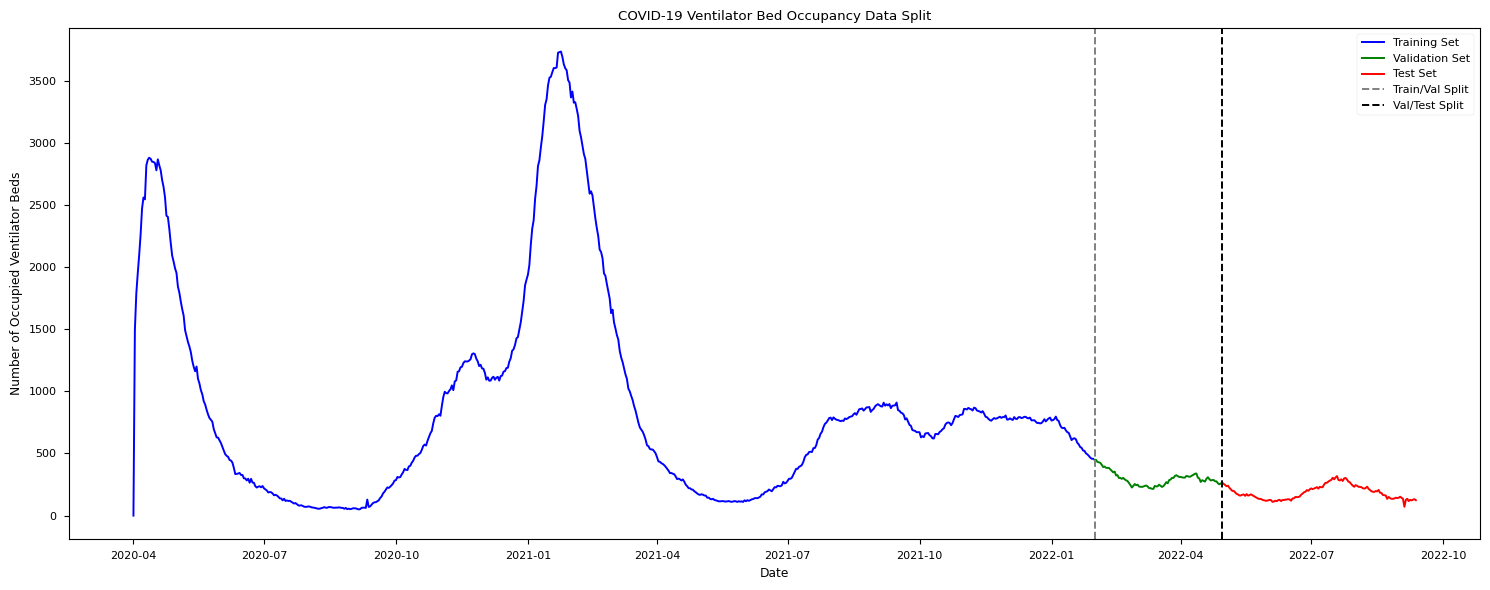

In [13]:
# %%
# Visualize the data split
# setting for making the plot suitable for a research paper
plt.style.use('seaborn-v0_8-paper')

plt.figure(figsize=(15, 6))
plt.plot(train['date'], train['covidOccupiedMVBeds'], 'b-', label='Training Set')
plt.plot(val['date'], val['covidOccupiedMVBeds'], 'g-', label='Validation Set')
plt.plot(test['date'], test['covidOccupiedMVBeds'], 'r-', label='Test Set')
plt.axvline(x=train_end, color='gray', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end, color='black', linestyle='--', label='Val/Test Split')
plt.title('COVID-19 Ventilator Bed Occupancy Data Split')
plt.xlabel('Date')
plt.ylabel('Number of Occupied Ventilator Beds')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/data_split.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# %% [markdown]
# ## Feature Selection and Data Preparation

# %%
# Drop the 'areaName' column as it's no longer needed
train = train.drop('areaName', axis=1)
val = val.drop('areaName', axis=1)
test = test.drop('areaName', axis=1)

# Convert date to datetime and set as index
train.set_index("date", inplace=True)
val.set_index("date", inplace=True)
test.set_index("date", inplace=True)

# Concatenate the DataFrames for reference
sample_df = pd.concat([train, val, test])

# Convert feature columns to float32 for efficiency and compatibility with deep learning
for col in sample_df.columns:
    if col != "type":
        sample_df[col] = sample_df[col].astype("float32")

print(f"Combined dataframe shape: {sample_df.shape}")

Combined dataframe shape: (895, 107)


In [15]:
# Let's use feature importance from a baseline model to select the most relevant features

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Define the target variable
target = "covidOccupiedMVBeds"

# Prepare X and y for feature selection
X_train = train.drop(target, axis=1)
y_train = train[target]

# Remove high cardinality categorical features and time-based features that would leak information
exclude_cols = ['date'] if 'date' in X_train.columns else []
exclude_cols.extend([col for col in X_train.columns if 'season_' in col])
X_train = X_train.drop(exclude_cols, axis=1)

# Clean the data: replace inf, -inf with NaN, then fill NaN with column means
X_train_cleaned = X_train.replace([np.inf, -np.inf], np.nan)
column_means = X_train_cleaned.mean()
X_train_cleaned = X_train_cleaned.fillna(column_means)

# Check if there are still any problematic values
print("Checking for remaining inf or NaN values:")
print(f"  Inf values: {np.any(np.isinf(X_train_cleaned.values))}")
print(f"  NaN values: {np.any(np.isnan(X_train_cleaned.values))}")

# Convert to float64 to handle potential precision issues
X_train_cleaned = X_train_cleaned.astype('float64')

# Track time for feature selection
start_time = time.time()
print("Starting feature selection...")

# Use correlation as a simple feature selection method
correlations = X_train_cleaned.corrwith(y_train).abs().sort_values(ascending=False)
top_corr_features = correlations.head(30).index.tolist()

# Additionally, try Random Forest with robust error handling
try:
    rf = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X_train_cleaned, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    feature_importances = pd.DataFrame({'feature': X_train_cleaned.columns, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    
    # Select top features from RF
    top_rf_features = feature_importances.head(30)['feature'].tolist()
    
    # Combine both selection methods
    top_features = list(set(top_corr_features + top_rf_features))
    selection_method = "Combined correlation and Random Forest"
except Exception as e:
    print(f"Random Forest feature selection failed with error: {e}")
    print("Falling back to correlation-based feature selection only")
    top_features = top_corr_features
    feature_importances = pd.DataFrame({'feature': correlations.index, 'importance': correlations.values})
    selection_method = "Correlation only"

print(f"Feature selection ({selection_method}) completed in {time.time() - start_time:.2f} seconds")
print(f"Selected {len(top_features)} most important features")

Checking for remaining inf or NaN values:
  Inf values: False
  NaN values: False
Starting feature selection...
Feature selection (Combined correlation and Random Forest) completed in 1.63 seconds
Selected 41 most important features


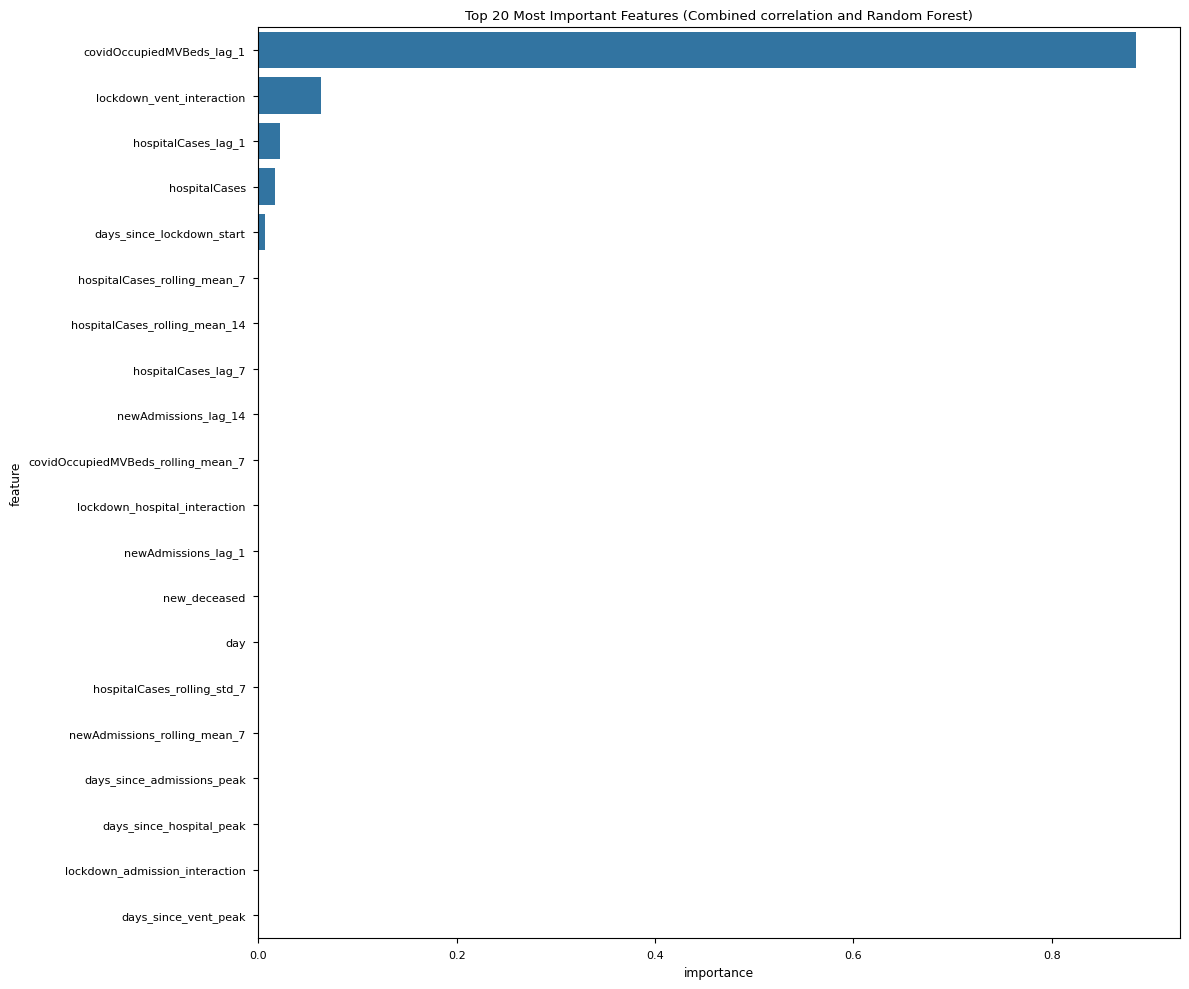

In [16]:
# Visualize feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title(f'Top 20 Most Important Features ({selection_method})')
plt.tight_layout()
plt.show()

In [17]:
# # Analyze feature importance by perturbing the input data
# feature_importance = {}

# # Select a subset of features to analyze to save time
# features_to_analyze = final_features[:15] if len(final_features) >= 15 else final_features  # Analyze top 15 features

# try:
#     for feature in features_to_analyze:
#         # Create a copy of the test data
#         test_perturbed = test.copy()
        
#         # Shuffle the feature values
#         test_perturbed[feature] = np.random.permutation(test_perturbed[feature].values)
        
#         # Handle potential inf or NaN values
#         test_perturbed.replace([np.inf, -np.inf], np.nan, inplace=True)
#         test_perturbed.fillna(test_perturbed.mean(), inplace=True)
        
#         # Prepare data for prediction
#         perturbed_data = selected_df.copy()
#         perturbed_data.loc[test_perturbed.index, feature] = test_perturbed[feature]
        
#         # Ensure no inf or NaN values
#         perturbed_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#         perturbed_data.fillna(perturbed_data.mean(), inplace=True)
        
#         # Create a new datamodule with the perturbed data
#         try:
#             perturbed_datamodule = TimeSeriesDataModule(
#                 data=perturbed_data,
#                 n_val=val.shape[0],
#                 n_test=test.shape[0],
#                 window=window_size,
#                 horizon=horizon,
#                 normalize="global",
#                 batch_size=32,
#                 num_workers=2,  # Reduced to avoid potential memory issues
#             )
#             perturbed_datamodule.setup()
            
#             # Make predictions with the perturbed data
#             perturbed_pred = trainer.predict(lstm_model, perturbed_datamodule.test_dataloader())
#             perturbed_pred = torch.cat(perturbed_pred).squeeze().detach().numpy()
#             perturbed_pred = perturbed_pred * perturbed_datamodule.train.std + perturbed_datamodule.train.mean
            
#             # Calculate the increase in error due to perturbation
#             original_mse = mean_squared_error(actuals, pred)
#             perturbed_mse = mean_squared_error(actuals, perturbed_pred)
            
#             # Feature importance is the percentage increase in error
#             importance = (perturbed_mse - original_mse) / original_mse * 100
#             feature_importance[feature] = importance
#             print(f"Analyzed importance of {feature}: {importance:.2f}%")
#         except Exception as e:
#             print(f"Error analyzing feature {feature}: {e}")
#             feature_importance[feature] = 0  # Assign zero importance to problematic features
# except Exception as e:
#     print(f"Feature importance analysis failed with error: {e}")
#     print("Skipping detailed feature importance analysis")

In [18]:
sample_df.head()

,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,openstreetmap_id,...,season_3,season_4,covid_wave,wave_momentum,lockdown_hospital_interaction,lockdown_admission_interaction,lockdown_vent_interaction,hospitalCases_lockdown_effect,newAdmissions_lockdown_effect,covidOccupiedMVBeds_lockdown_effect
date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,0.0,23332.0,12059.0,3099.0,3989.0,694.0,35571.0,4730.0,56171304.0,151336.0,...,0.0,0.0,0.0,0.0,12059.0,3099.0,0.0,0.0,0.0,0.0
2020-04-02,1494.0,26264.0,12135.0,2932.0,3895.0,725.0,39466.0,5455.0,56171304.0,151336.0,...,0.0,0.0,0.0,0.0,12135.0,2932.0,1494.0,0.0,0.0,0.0
2020-04-03,1788.0,28828.0,13635.0,2564.0,3878.0,737.0,43344.0,6192.0,56171304.0,151336.0,...,0.0,0.0,1.0,0.0,13635.0,2564.0,1788.0,0.0,0.0,0.0
2020-04-04,1950.0,31421.0,15469.0,2593.0,3260.0,828.0,46604.0,7020.0,56171304.0,151336.0,...,0.0,0.0,1.0,0.0,15469.0,2593.0,1950.0,0.0,0.0,0.0
2020-04-05,2097.0,34013.0,16657.0,2592.0,2994.0,823.0,49598.0,7843.0,56171304.0,151336.0,...,0.0,0.0,1.0,0.0,16657.0,2592.0,2097.0,0.0,0.0,0.0


In [19]:
# %%
# Define features based on our selection and domain knowledge
# Base features from key indicators
base_features = [
    'covidOccupiedMVBeds_lag_1',  # Previous day's ventilator beds
    'covidOccupiedMVBeds_lag_7',  # One week ago ventilator beds
    'covidOccupiedMVBeds_rolling_mean_7',  # Weekly average
    # 'covidOccupiedMVBeds_rolling_std_7',   # Weekly standard deviation
    'covidOccupiedMVBeds_rolling_mean_14',  # Bi-weekly average
    # 'covidOccupiedMVBeds_rolling_std_14',   # Bi-weekly standard deviation
    'hospitalCases',               # Current hospital cases
    'newAdmissions',               # New hospital admissions
    'new_confirmed',               # New COVID cases
    'Vax_index'                    # Vaccination effect
]

# Add selected features from the Random Forest
# Include top lockdown, ratio and momentum features from our feature importance ranking
selected_features = base_features.copy()
for feature in top_features:
    if (feature not in selected_features and 
        ('lockdown' in feature or 
         'ratio' in feature or 
         'momentum' in feature or 
         'acceleration' in feature or
         'wave' in feature or
         'peak' in feature)):
        selected_features.append(feature)

# Also add calendar features which are important for capturing weekly patterns
calendar_features = [
    'day_of_week',
    'is_weekend',
    'is_holiday',
    'day',
    'month',
    'year',
    'week_of_year',
]

# Combine all features
selected_features.extend([f for f in calendar_features if f not in selected_features])

# Keep only features that exist in the dataframe
final_features = [f for f in selected_features if f in sample_df.columns]
print(f"Final feature count: {len(final_features)}")

# Select the features and the target variable for our model
selected_df = sample_df[final_features + [target]]

# %%
# Display correlation between features and target
correlation_with_target = selected_df.corr()[target].sort_values(ascending=False)
print("Top correlations with ventilator bed occupancy:")
print(correlation_with_target.head(10))
print("\nBottom correlations with ventilator bed occupancy:")
print(correlation_with_target.tail(5))




Final feature count: 28
Top correlations with ventilator bed occupancy:
covidOccupiedMVBeds                    1.000000
covidOccupiedMVBeds_lag_1              0.996916
covidOccupiedMVBeds_rolling_mean_7     0.976880
covidOccupiedMVBeds_lag_7              0.942005
covidOccupiedMVBeds_rolling_mean_14    0.912869
lockdown_vent_interaction              0.903874
lockdown_hospital_interaction          0.879740
days_until_lockdown_end                0.833895
lockdown_admission_interaction         0.826822
covid_wave                             0.813369
Name: covidOccupiedMVBeds, dtype: float64

Bottom correlations with ventilator bed occupancy:
days_since_lockdown_1_start   -0.356182
days_since_vent_peak          -0.453708
days_since_admissions_peak    -0.483560
days_since_hospital_peak      -0.490904
days_since_lockdown_start     -0.514241
Name: covidOccupiedMVBeds, dtype: float64


In [20]:
# # Calculate the correlation of all features with the target variable
# correlations = selected_df.corr()[target]

# # Identify features that are positively correlated (including the target)
# positive_features = correlations[correlations > 0].index.tolist()

# # Select only the positively correlated features from the dataframe
# selected_positive_df = selected_df[positive_features]

# print("Positively correlated features:")
# print(selected_positive_df.columns.tolist())

In [21]:
# selected_df = selected_positive_df

In [22]:
# %%
# Ensure the target column is the last column (important for the model)
cols = list(selected_df.columns)
if target in cols:
    cols.remove(target)
    selected_df = selected_df[cols + [target]]

# Display info about the selected dataframe
print("Selected dataframe info:")
selected_df.info()

Selected dataframe info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 895 entries, 2020-04-01 to 2022-09-12
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   covidOccupiedMVBeds_lag_1            895 non-null    float32
 1   covidOccupiedMVBeds_lag_7            895 non-null    float32
 2   covidOccupiedMVBeds_rolling_mean_7   895 non-null    float32
 3   covidOccupiedMVBeds_rolling_mean_14  895 non-null    float32
 4   hospitalCases                        895 non-null    float32
 5   newAdmissions                        895 non-null    float32
 6   new_confirmed                        895 non-null    float32
 7   Vax_index                            895 non-null    float32
 8   lockdown_vent_interaction            895 non-null    float32
 9   days_since_vent_peak                 895 non-null    float32
 10  lockdown_admission_interaction       895 non-null    f

In [23]:
# %% [markdown]
# ## Model Development
# 
# We'll use an LSTM model for time series forecasting, which is well-suited for capturing temporal patterns.

# %%
# Create a TimeSeriesDataModule for the model
window_size = 14  # Use two weeks of data to predict
horizon = 1       # Predict one day ahead

datamodule = TimeSeriesDataModule(
    data=selected_df,
    n_val=val.shape[0],
    n_test=test.shape[0],
    window=window_size, 
    horizon=horizon,  
    normalize="global",  # Normalize across all data
    batch_size=32,
)
datamodule.setup()

# Get the actual input size from the datamodule
X_sample, _ = next(iter(datamodule.train_dataloader()))
actual_input_size = X_sample.shape[2]
print(f"Actual input size from dataloader: {actual_input_size}")

# %%
# Define model configurations
lstm_config = SingleStepRNNConfig(
    rnn_type="LSTM",  # Use LSTM instead of vanilla RNN
    input_size=actual_input_size,
    hidden_size=128,   # Increased from 64
    num_layers=5,      # Increased from 2 for better generalization
    bidirectional=True,  # Use bidirectional LSTM
    learning_rate=5e-4   # Decreased to avoid overshooting
)

# Create the LSTM model
lstm_model = SingleStepRNNModel(lstm_config)
lstm_model.to(device)

# Check total number of parameters
total_params = sum(p.numel() for p in lstm_model.parameters())
print(f"Total number of parameters: {total_params:,}")

Actual input size from dataloader: 29
Total number of parameters: 1,744,129


In [24]:
# %% [markdown]
# ## Model Training with Better Configurations

# %%
# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(
    monitor="valid_loss",
    patience=10,
    verbose=True,
    mode="min"
)

model_checkpoint = ModelCheckpoint(
    monitor="valid_loss",
    dirpath="./checkpoints/",
    filename="covid-lstm-{epoch:02d}-{valid_loss:.4f}",
    save_top_k=1,
    mode="min"
)

# Train the model with improved settings
trainer = pl.Trainer(
    min_epochs=10,
    max_epochs=100,
    callbacks=[early_stopping, model_checkpoint],
    gradient_clip_val=0.5,  # Prevent exploding gradients
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed' if torch.cuda.is_available() else '32',  # Use mixed precision if GPU is available
    log_every_n_steps=10
)

# Start timing the training
train_start_time = time.time()
print("Starting model training...")

# Train the model
trainer.fit(lstm_model, datamodule)

# Calculate training time
train_time = time.time() - train_start_time
print(f"Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Starting model training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 1.7 M 
1 | fc   | Linear  | 257   
2 | loss | MSELoss | 0     
---------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.977     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 21/21 [00:00<00:00, 21.39it/s, v_num=35, train_loss=0.00293, valid_loss=0.00646, valid_MAE=0.0771, train_MAE=0.0705]

Metric valid_loss improved. New best score: 0.006


Epoch 10: 100%|██████████| 21/21 [00:00<00:00, 30.31it/s, v_num=35, train_loss=0.000297, valid_loss=0.00864, valid_MAE=0.0845, train_MAE=0.00896]

Monitored metric valid_loss did not improve in the last 10 records. Best score: 0.006. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 21/21 [00:00<00:00, 30.01it/s, v_num=35, train_loss=0.000297, valid_loss=0.00864, valid_MAE=0.0845, train_MAE=0.00896]
Training completed in 14.17 seconds (0.24 minutes)


In [25]:
# %%
# Clean up any artifacts created during training
import shutil
if os.path.exists("lightning_logs"):
    shutil.rmtree("lightning_logs")


In [26]:
# %% [markdown]
# ## Model Evaluation

# %%
# Define utility functions for metrics
def mase(actual, predicted, insample_actual):
    """
    Calculate the Mean Absolute Scaled Error (MASE).
    
    Args:
        actual (np.array): Actual values.
        predicted (np.array): Predicted values.
        insample_actual (np.array): In-sample actual values for scaling.
    
    Returns:
        float: The MASE value.
    """
    mae_insample = np.mean(np.abs(np.diff(insample_actual)))
    if mae_insample == 0:
        return np.nan
    mae_outsample = np.mean(np.abs(actual - predicted))
    return mae_outsample / mae_insample

def forecast_bias(actual, predicted):
    """
    Calculate the forecast bias.
    
    Args:
        actual (np.array): Actual values.
        predicted (np.array): Predicted values.
    
    Returns:
        float: The forecast bias.
    """
    return np.mean(predicted - actual)

# %%
# Format a plotly plot for the forecast
def format_plot(
    fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15
):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig

def plot_forecast(pred_df, forecast_columns, forecast_display_names=None, save_path=None):
    """
    Plot the forecasted values against actual values.
    
    Args:
        pred_df (pd.DataFrame): DataFrame containing actual and predicted values.
        forecast_columns (list): List of columns with forecasted data.
        forecast_display_names (list, optional): Display names for the forecasted columns.
        save_path (str, optional): Path to save the plot.
    
    Returns:
        plotly.graph_objects.Figure: The forecast plot.
    """
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = px.colors.qualitative.Set2
    act_color = colors[0]
    colors = cycle(colors[1:])

    fig = go.Figure()

    # Actual Data Plot
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[target][mask],  # Fixed column reference
            mode="lines",
            line=dict(color=act_color, width=2),
            name="Actual COVID-19 MVBeds Trends",
        )
    )

    # Predicted Data Plots
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(color=next(colors), width=2),
                name=display_col,
            )
        )

    return fig

In [27]:
# %%
# Evaluate the model and calculate metrics
metric_record = []

# Get predictions for test set
pred = trainer.predict(lstm_model, datamodule.test_dataloader())
pred = torch.cat(pred).squeeze().detach().numpy()

# Denormalize predictions using datamodule's statistics
pred = pred * datamodule.train.std + datamodule.train.mean

# Get actual values from test set
actuals = test[target].values

# Calculate metrics
metrics = {
    "Algorithm": lstm_config.rnn_type,
    "MAE": mean_absolute_error(actuals, pred),
    "MSE": mean_squared_error(actuals, pred),
    "RMSE": np.sqrt(mean_squared_error(actuals, pred)),
    "MAPE": mean_absolute_percentage_error(actuals, pred) * 100,  # Convert to percentage
    "MASE": mase(actuals, pred, train[target].values),
    "Forecast Bias": forecast_bias(actuals, pred),
}

# Print metrics in a formatted way
print(f"Performance metrics for {lstm_config.rnn_type} model:")
print(f"MAE: {metrics['MAE']:.2f} ventilator beds")
print(f"RMSE: {metrics['RMSE']:.2f} ventilator beds")
print(f"MAPE: {metrics['MAPE']:.2f}%")
print(f"MASE: {metrics['MASE']:.4f}")
print(f"Forecast Bias: {metrics['Forecast Bias']:.2f} ventilator beds")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 94.34it/s] 
Performance metrics for LSTM model:
MAE: 394.12 ventilator beds
RMSE: 438.30 ventilator beds
MAPE: 201.85%
MASE: 14.8135
Forecast Bias: 394.12 ventilator beds


In [28]:
# %%
# 1. Create DataFrame with the LSTM forecast
pred_df = pd.DataFrame({"LSTM Forecast": pred}, index=test.index)

# 2. Join with the actual target data for comparison
pred_df = test[[target]].join(pred_df)

# 3. Generate your Plotly figure
fig = plot_forecast(
    pred_df,
    forecast_columns=["LSTM Forecast"],
    forecast_display_names=["LSTM with Enhanced Features"]
)

# 4. Build title & subtitle (HTML formatting for subtitle)
title_main = "COVID-19 Ventilator Bed Occupancy: Actual vs Forecast"
subtitle = (
    f"MAE: {metrics['MAE']:.2f} | "
    f"RMSE: {metrics['RMSE']:.2f} | "
    f"MASE: {metrics['MASE']:.4f} | "
    f"Forecast Bias: {metrics['Forecast Bias']:.2f}"
)
title = f"{title_main}<br><sub>{subtitle}</sub>"

# 5. Apply your custom formatting (axes labels, etc.)
fig = format_plot(fig, title=title, xlabel="Date", ylabel="Ventilator Beds")

# 6. Update layout for better spacing and a neat, centered legend
fig.update_layout(
    margin=dict(t=100, b=60, l=60, r=60),  # extra top margin for title/subtitle
    title={
        "text": title,
        "x": 0.5,
        "xanchor": "center",
        "y": 0.95,
        "yanchor": "top"
    },
    showlegend=True,
    legend=dict(
        orientation="h",           # horizontal legend
        x=0.5,                     # center horizontally
        xanchor="center",
        y=1.1,                    # place below subtitle
        yanchor="top",
        font=dict(size=10)         # smaller text for legend
        # ncol=2 or more if you want multiple columns
    )
)

# 7. Use a date axis for clarity
fig.update_xaxes(type="date")

# 8. Display the final figure
fig.show()


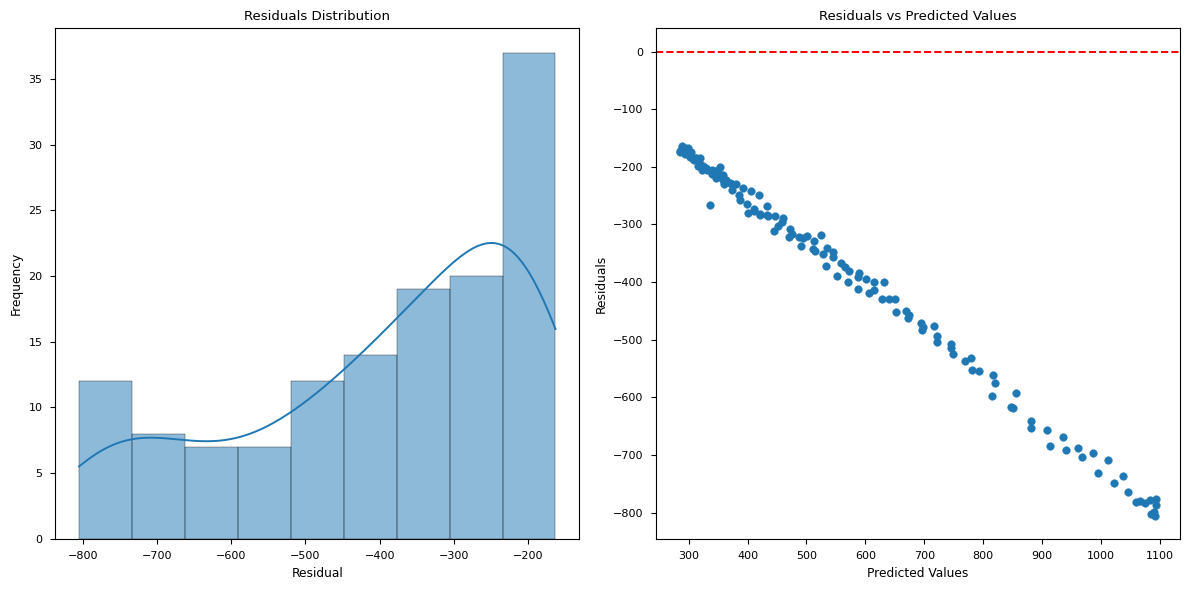

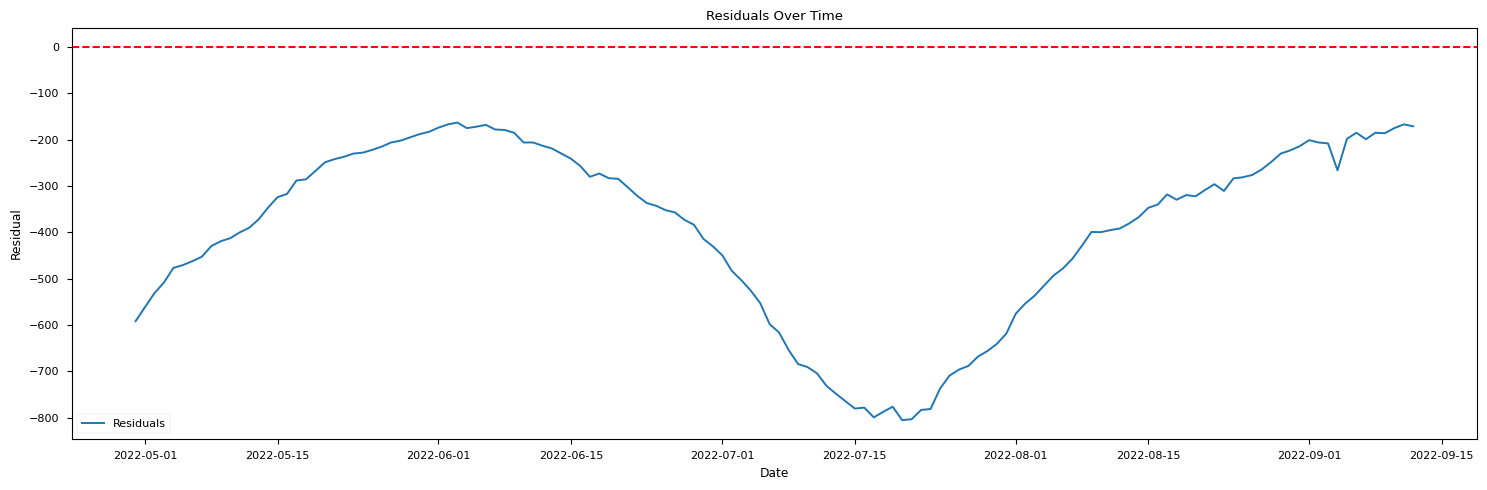

In [29]:
# %%
# Plot residuals (error analysis)
residuals = actuals - pred
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.scatter(pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Plot residuals over time
plt.figure(figsize=(15, 5))
plt.plot(test.index, residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 35.97it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of covidOccupiedMVBeds_lag_1: -0.58%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 29.12it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of covidOccupiedMVBeds_lag_7: -0.26%
Predicting DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Error analyzing feature covidOccupiedMVBeds_rolling_mean_7: Input and parameter tensors are not the same dtype, found input tensor with Double and parameter tensor with Half
Predicting DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Error analyzing feature covidOccupiedMVBeds_rolling_mean_14: Input and parameter tensors are not the same dtype, found input tensor with Double and parameter tensor with Half
Predicting: |          | 0/? [00:04<?, ?it/s]
Predicting: |          | 5/? [00:04<00:00,  1.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of hospitalCases: -22.87%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 54.35it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of newAdmissions: -5.61%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 32.99it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of new_confirmed: -8.23%
Predicting DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Error analyzing feature Vax_index: Input and parameter tensors are not the same dtype, found input tensor with Double and parameter tensor with Half
Predicting DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]
Predicting: |          | 5/? [00:03<00:00,  1.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of lockdown_vent_interaction: 0.00%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 27.32it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of days_since_vent_peak: 0.01%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 31.25it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of lockdown_admission_interaction: 0.00%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 29.41it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of lockdown_hospital_interaction: 0.00%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 13.21it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of days_until_lockdown_3_end: 0.00%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 18.59it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzed importance of days_since_hospital_peak: 0.01%
Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 30.18it/s] 
Analyzed importance of covid_wave: 0.00%


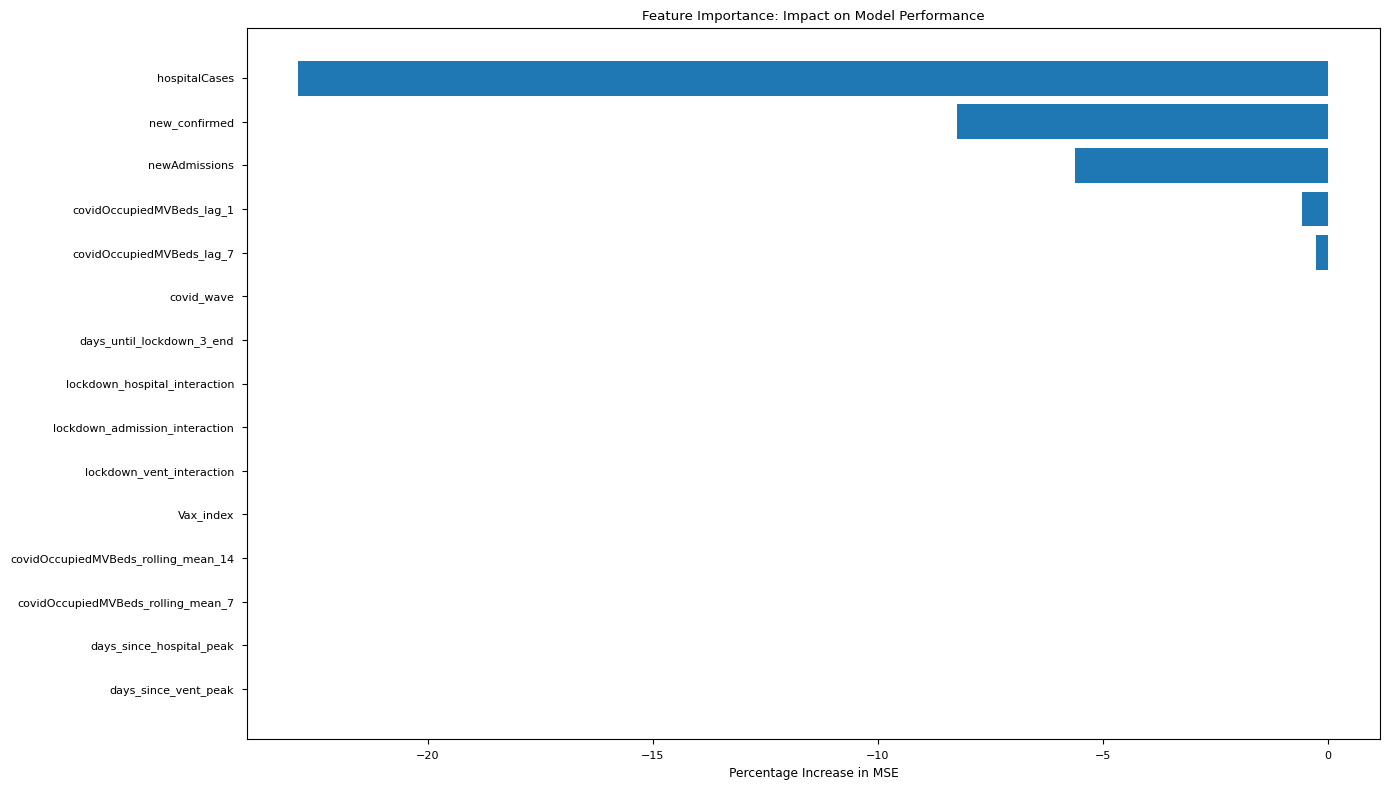

In [30]:
# %% [markdown]
# ## Feature Importance Analysis

# %%
# Analyze feature importance by perturbing the input data
feature_importance = {}

# Select a subset of features to analyze to save time
features_to_analyze = final_features[:15] if len(final_features) >= 15 else final_features  # Analyze top 15 features

try:
    for feature in features_to_analyze:
        # Create a copy of the test data
        test_perturbed = test.copy()
        
        # Shuffle the feature values
        test_perturbed[feature] = np.random.permutation(test_perturbed[feature].values)
        
        # Handle potential inf or NaN values
        test_perturbed.replace([np.inf, -np.inf], np.nan, inplace=True)
        test_perturbed.fillna(test_perturbed.mean(), inplace=True)
        
        # Prepare data for prediction
        perturbed_data = selected_df.copy()
        perturbed_data.loc[test_perturbed.index, feature] = test_perturbed[feature]
        
        # Ensure no inf or NaN values
        perturbed_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        perturbed_data.fillna(perturbed_data.mean(), inplace=True)
        
        # Create a new datamodule with the perturbed data
        try:
            perturbed_datamodule = TimeSeriesDataModule(
                data=perturbed_data,
                n_val=val.shape[0],
                n_test=test.shape[0],
                window=window_size,
                horizon=horizon,
                normalize="global",
                batch_size=32,
                num_workers=2,  # Reduced to avoid potential memory issues
            )
            perturbed_datamodule.setup()
            
            # Make predictions with the perturbed data
            perturbed_pred = trainer.predict(lstm_model, perturbed_datamodule.test_dataloader())
            perturbed_pred = torch.cat(perturbed_pred).squeeze().detach().numpy()
            perturbed_pred = perturbed_pred * perturbed_datamodule.train.std + perturbed_datamodule.train.mean
            
            # Calculate the increase in error due to perturbation
            original_mse = mean_squared_error(actuals, pred)
            perturbed_mse = mean_squared_error(actuals, perturbed_pred)
            
            # Feature importance is the percentage increase in error
            importance = (perturbed_mse - original_mse) / original_mse * 100
            feature_importance[feature] = importance
            print(f"Analyzed importance of {feature}: {importance:.2f}%")
        except Exception as e:
            print(f"Error analyzing feature {feature}: {e}")
            feature_importance[feature] = 0  # Assign zero importance to problematic features
except Exception as e:
    print(f"Feature importance analysis failed with error: {e}")
    print("Skipping detailed feature importance analysis")

# %%
# Only plot feature importance if we have data
if feature_importance:
    # Sort features by importance
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    
    # Plot feature importance
    plt.figure(figsize=(14, 8))
    plt.barh(list(feature_importance.keys()), list(feature_importance.values()))
    plt.xlabel('Percentage Increase in MSE')
    plt.title('Feature Importance: Impact on Model Performance')
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data to visualize.")

In [31]:
# %% [markdown]
# ## Model Comparison: LSTM vs. Baseline Models

# %%
# Implement simple baseline models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Prepare lagged features for baseline models
def create_features(df, target, lag=7):
    X = df.copy()
    # Add lags
    for i in range(1, lag + 1):
        X[f'{target}_lag_{i}'] = X[target].shift(i)
    
    # Drop rows with NaN values
    X = X.dropna()
    
    return X

# Create training and test sets for baseline models
train_baseline = create_features(train.reset_index(), target, lag=window_size)
test_baseline = create_features(test.reset_index(), target, lag=window_size)

# Features (X) and target (y)
X_train_baseline = train_baseline.drop(['date', target], axis=1)
y_train_baseline = train_baseline[target]
X_test_baseline = test_baseline.drop(['date', target], axis=1)
y_test_baseline = test_baseline[target]

# Standardize features
scaler = StandardScaler()
X_train_baseline_scaled = scaler.fit_transform(X_train_baseline)
X_test_baseline_scaled = scaler.transform(X_test_baseline)

# Train baseline models
baseline_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=SEED)
}

baseline_predictions = {}
baseline_metrics = {}

for name, model in baseline_models.items():
    # Train model
    model.fit(X_train_baseline_scaled, y_train_baseline)
    
    # Make predictions
    y_pred = model.predict(X_test_baseline_scaled)
    baseline_predictions[name] = y_pred
    
    # Calculate metrics
    baseline_metrics[name] = {
        'MAE': mean_absolute_error(y_test_baseline, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_baseline, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_test_baseline, y_pred) * 100,
        'MASE': mase(y_test_baseline, y_pred, train[target].values),
        'Forecast Bias': forecast_bias(y_test_baseline, y_pred)
    }


In [32]:
if baseline_predictions:
    # Add baseline predictions to the visualization
    for name, y_pred in baseline_predictions.items():
        pred_df[name] = np.nan
        
        # Handle index differences safely
        common_indices = pred_df.index.intersection(test_baseline['date'])
        if len(common_indices) > 0:
            # Create an index-matching dictionary
            index_map = {date: i for i, date in enumerate(test_baseline['date'])}
            
            # Update values only for matching dates
            for date in common_indices:
                if date in index_map:
                    idx = index_map[date]
                    if idx < len(y_pred):  # Ensure we don't go out of bounds
                        pred_df.loc[date, name] = y_pred[idx]
        else:
            print(f"Warning: No matching indices found for {name} predictions")
    
    # Create comparison plot with LSTM + baseline forecasts
    forecast_columns = ["LSTM Forecast"] + list(baseline_predictions.keys())
    forecast_display_names = ["LSTM"] + list(baseline_predictions.keys())
    
    fig = plot_forecast(pred_df, forecast_columns, forecast_display_names)
    title_text = "COVID-19 Ventilator Bed Occupancy: Model Comparison"
    fig = format_plot(fig, title=title_text, xlabel="Date", ylabel="Ventilator Beds")
    
    # Update layout: Centered legend, below the title, horizontally
    fig.update_layout(
        margin=dict(t=100, b=60, l=60, r=60),
        title={
            "text": title_text,
            "x": 0.5,
            "xanchor": "center",
            "y": 0.95,
            "yanchor": "top"
        },
        showlegend=True,
        legend=dict(
            orientation="h",           # horizontal orientation
            x=0.5,                     # center horizontally
            xanchor="center",
            y=1.1,                     # place legend below title
            yanchor="top",
            font=dict(size=10),
            # ncol=5  # set if you want all items on a single line
        )
    )
    
    fig.update_xaxes(type="date")
    fig.show()

else:
    # Show only LSTM predictions if baseline models are unavailable
    fig = plot_forecast(pred_df, 
                        forecast_columns=["LSTM Forecast"], 
                        forecast_display_names=["LSTM with Enhanced Features"])
    
    title_text = "COVID-19 Ventilator Bed Occupancy: LSTM Forecast"
    fig = format_plot(fig, title=title_text, xlabel="Date", ylabel="Ventilator Beds")
    
    # Same legend styling for consistency
    fig.update_layout(
        margin=dict(t=100, b=60, l=60, r=60),
        title={
            "text": title_text,
            "x": 0.5,
            "xanchor": "center",
            "y": 0.95,
            "yanchor": "top"
        },
        showlegend=True,
        legend=dict(
            orientation="h",
            x=0.5,
            xanchor="center",
            y=1.1,
            yanchor="top",
            font=dict(size=10),
            # ncol=5  # set if you want all items on a single line
        )
    )
    
    fig.update_xaxes(type="date")
    fig.show()
    print("No baseline predictions available for comparison.")
